In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import random, math, gc
from PIL import Image
import requests
from io import BytesIO

# ---- FORCE GPU ----
assert torch.cuda.is_available(), "Enable GPU: Runtime → Change runtime type → GPU"
device = torch.device("cuda:0")
print("Using GPU:", torch.cuda.get_device_name(0))

torch.backends.cudnn.benchmark = True

Using GPU: Tesla T4


In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [12]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
vit = vit_b_16(weights=weights).to(device)
vit.eval()

preprocess = weights.transforms()
class_names = weights.meta["categories"]

print("ViT hidden dim:", vit.hidden_dim)

ViT hidden dim: 768


In [16]:
def load_url(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    r = requests.get(url, headers=headers, timeout=20)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

images = [
    load_url("https://picsum.photos/224/224?random=1"),
    load_url("https://picsum.photos/224/224?random=2"),
    load_url("https://picsum.photos/224/224?random=3"),
]

print("Loaded images:", len(images))

Loaded images: 3


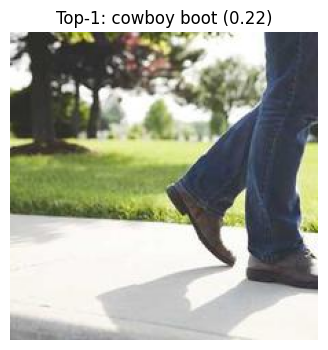

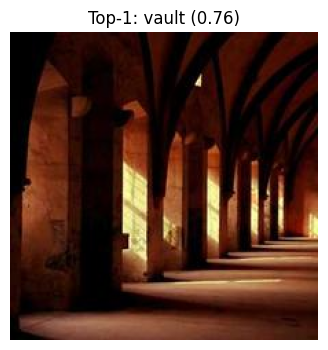

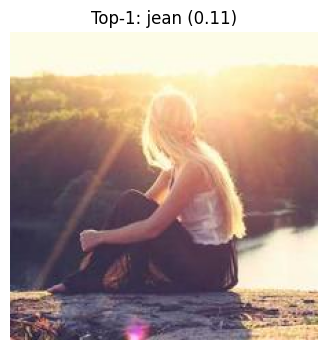

In [17]:
@torch.no_grad()
def classify(img):
    x = preprocess(img).unsqueeze(0).to(device)
    logits = vit(x)
    probs = torch.softmax(logits, dim=1)[0]
    idx = probs.argmax().item()
    return class_names[idx], probs[idx].item()

for i, img in enumerate(images):
    label, conf = classify(img)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Top-1: {label} ({conf:.2f})")
    plt.axis("off")
    plt.show()

In [19]:
attn_maps = []

def attn_hook(module, inp, out):
    attn_weights = out[1]
    attn_maps.append(attn_weights)

vit.encoder.layers[-1].self_attention.register_forward_hook(attn_hook)


In [20]:
@torch.no_grad()
def visualize_attention(img):
    attn_maps.clear()
    x = preprocess(img).unsqueeze(0).to(device)
    _ = vit(x)

    attn = attn_maps[0]
    attn = attn.mean(dim=1)[0]
    cls_attn = attn[0, 1:]

    grid = int(math.sqrt(cls_attn.numel()))
    attn_2d = cls_attn.reshape(grid, grid).detach().cpu().numpy()
    attn_2d = (attn_2d - attn_2d.min()) / (attn_2d.max() + 1e-8)

    attn_up = torch.tensor(attn_2d)[None,None,:,:]
    attn_up = torch.nn.functional.interpolate(
        attn_up, size=(224,224), mode="bilinear", align_corners=False
    )[0,0].numpy()

    img224 = img.resize((224,224))
    img_np = np.array(img224)/255.0
    overlay = img_np.copy()
    overlay[...,0] += attn_up * 0.5
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img224); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(attn_2d, cmap="Reds"); plt.title("CLS attention"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()


In [21]:
def mask_patches(x, mask_ratio=0.25, mode="random", patch=16):
    B,C,H,W = x.shape
    g = H // patch
    total = g*g
    m = int(mask_ratio * total)
    x = x.clone()

    if m == 0:
        return x

    if mode == "random":
        idx = torch.randperm(total)[:m]
        for t in idx:
            r, c = divmod(t.item(), g)
            x[:,:,r*patch:(r+1)*patch, c*patch:(c+1)*patch] = 0

    elif mode == "center":
        s = int(math.sqrt(m))
        r0 = (g - s)//2
        c0 = (g - s)//2
        x[:,:,r0*patch:(r0+s)*patch, c0*patch:(c0+s)*patch] = 0

    return x


In [22]:
@torch.no_grad()
def masked_accuracy(imgs, mask_ratio, mode):
    correct = 0
    for img in imgs:
        x = preprocess(img).unsqueeze(0).to(device)
        x = mask_patches(x, mask_ratio, mode)
        pred = vit(x).argmax(1).item()
        if class_names[pred] == classify(img)[0]:
            correct += 1
    return correct / len(imgs)

for r in [0.0, 0.25, 0.5]:
    print(f"Mask {r:.2f} random:", masked_accuracy(images, r, "random"))
    print(f"Mask {r:.2f} center:", masked_accuracy(images, r, "center"))


Mask 0.00 random: 1.0
Mask 0.00 center: 1.0
Mask 0.25 random: 0.6666666666666666
Mask 0.25 center: 0.6666666666666666
Mask 0.50 random: 0.3333333333333333
Mask 0.50 center: 0.6666666666666666


In [23]:
class LinearProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d, 10)
    def forward(self, x):
        return self.fc(x)

In [24]:
transform = preprocess

train_ds = torchvision.datasets.CIFAR10(
    root="/content/data", train=True, download=True, transform=transform
)
train_ds = torch.utils.data.Subset(train_ds, range(20000))

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


In [27]:
def train_probe(pool="cls", epochs=5):
    probe = LinearProbe(vit.hidden_dim).to(device)
    opt = optim.AdamW(probe.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    vit.eval()

    for ep in range(epochs):
        total, correct = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            with torch.no_grad():

                n = x.shape[0]
                x_patches = vit._process_input(x)
                cls = vit.class_token.expand(n, -1, -1)
                x_tokens = torch.cat([cls, x_patches], dim=1)
                x_tokens = x_tokens + vit.encoder.pos_embedding
                x_tokens = vit.encoder.dropout(x_tokens)
                enc = vit.encoder.layers(x_tokens)
                enc = vit.encoder.ln(enc)

                if pool == "cls":
                    feat = enc[:, 0]
                else:
                    feat = enc[:, 1:].mean(dim=1)

            logits = probe(feat)
            loss = loss_fn(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        print(f"[{pool}] epoch {ep+1}/{epochs} acc {correct/total:.3f}")

    return probe


In [28]:
probe_cls = train_probe("cls")
probe_mean = train_probe("mean")

[cls] epoch 1/5 acc 0.905
[cls] epoch 2/5 acc 0.946
[cls] epoch 3/5 acc 0.954
[cls] epoch 4/5 acc 0.958
[cls] epoch 5/5 acc 0.962
[mean] epoch 1/5 acc 0.804
[mean] epoch 2/5 acc 0.891
[mean] epoch 3/5 acc 0.908
[mean] epoch 4/5 acc 0.916
[mean] epoch 5/5 acc 0.923
